# Trust but Verify - Inspection of Large Image Collections

This notebook and accompanying [Python script characterize_data.py](characterize_data.py) illustrate the use of SimpleITK as a tool for efficient data inspection on large image collections, as part of familiarizing oneself with the data and performing cleanup prior to its use in deep learning or any other supervised machine learning approach.

The reasons for inspecting your data before using it include:
1. Identification of corrupt images.
2. Identification of erroneous images (label noise).
3. Assessment of data quality and variability in terms of intensity range, image resolution, and pixel types.
4. Reduction of workload, identifying redundant information content (e.g. a greyscale/single channel image masquerading as a color/three channel image - think x-ray in jpg file).


We inspect our data in two ways:
1. Summary of image characteristics found in a directory structure (generic and DICOM specific).
2. Visual inspection of the image content.

SimpleITK allows us to easily control for the image types we are interested in via the ImageIO. The currently supported/registered IO types are defined by the following strings:
* 'BMPImageIO'
* 'BioRadImageIO'
* 'Bruker2dseqImageIO'
* 'GDCMImageIO'
* 'GE4ImageIO'
* 'GE5ImageIO'
* 'GiplImageIO'
* 'HDF5ImageIO'
* 'JPEGImageIO'
* 'JPEG2000ImageIO'
* 'LSMImageIO'
* 'MINCImageIO'
* 'MRCImageIO'
* 'MetaImageIO'
* 'NiftiImageIO'
* 'NrrdImageIO'
* 'PNGImageIO'
* 'StimulateImageIO'
* 'TIFFImageIO'
* 'VTKImageIO'
* '' - empty string denotes all image file formats.

To see the set of ImageIO types supported by your version of SimpleITK, call [ImageFileReader::GetRegisteredImageIOs()](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ImageReaderBase.html#a4cbb7db3eb3796eee8d89a1aaf011511) or simply print an ImageFileReader object.

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import ipympl
from DicomSeriesHelper import *


# utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data)
OUTPUT_DIR = "Output"



In [2]:
%env SITK_SHOW_COMMAND /Applications/Slicer.app/Contents/MacOS/Slicer

env: SITK_SHOW_COMMAND=/Applications/Slicer.app/Contents/MacOS/Slicer


In [3]:
%matplotlib widget

In [4]:
data_root_dir = "/Users/seanreed/Documents/unlabeled-data/antech-ct"

In [5]:
!ls $data_root_dir

1.2.276.0.2783747.3.1.2.1150183542.91496.1584557269.16654
1.2.276.0.2783747.3.1.2.1150183542.91496.1584560923.16663
1.2.276.0.7230010.3.1.2.2733322860.4416.1572435955.336
1.2.276.0.7230010.3.1.2.738517100.4712.1625692712.6881
1.2.276.0.7230010.3.1.2.738517100.4712.1625694761.7821
1.2.276.0.7230010.3.1.2.738517100.4712.1625695650.8766
1.2.276.0.7230010.3.1.2.738517100.5904.1625697387.543
1.2.276.0.7230010.3.1.2.738517100.7560.1611692908.810
1.2.276.0.7230010.3.1.2.738517100.7560.1611699852.1756
1.2.392.200036.9116.2.2.2.1762671078.1544058796.778235
1.2.392.200036.9116.2.2.2.1762671078.1544062790.854133
1.2.392.200036.9116.2.2.2.1762671078.1544064007.853456
1.2.392.200036.9116.2.2.2.1762671078.1544065347.70543
1.2.392.200036.9116.2.2.2.1762671078.1544071914.125853
1.2.392.200036.9116.2.2.2.1762671078.1544074601.48209
1.2.392.200036.9116.2.2.2.1762671078.1544578457.236922
1.2.392.200036.9116.2.2.2.1762671078.1555384900.905993
1.2.392.200036.9116.2.2.2.1762671078.1557288274.152614
1.2.392.

## Characterizing  image set

To characterize the image set we have written a [Python script](characterize_data.py) that you should run from the command line. This script is very flexible and allows you to robustly characterize your image set. Try the various options and learn more about your data. You'd be surprised how many times the data isn't what you thought it is when only relying on visual inspection. The script allows you to inspect your data both on a file by file basis and as DICOM series where an image (volume) is stored in multiple files.

File by file:
```
python characterize_data.py data output/generic_image_data_report.csv per_file \
--imageIO "" --external_applications ./dciodvfy --external_applications_headings "DICOM Compliant" \
--metadata_keys "0008|0060" "0018|5101" --metadata_keys_headings "modality" "radiographic view"
```

DICOM series:
```
python characterize_data.py data output/DICOM_image_data_report.csv per_series \
--metadata_keys "0008|0060" "0018|5101" --metadata_keys_headings "modality" "radiographic view"  
```


After characterizing the image set we turn to visual inspection. 

In [ ]:
!python characterize_data.py --dir $data_root_dir --output "./Output/output_antech_ct_2.csv" --metadata_keys "0008|0060" "0018|5101" --metadata_keys_headings "modality" "radiographic view" 

## Visual inspection of  image set

While the reports generated above provide us with many insights with respect to the image content they are not sufficient for identifying erroneous images included in the dataset. For example if we expect our data to contain only frontal, AP or PA, chest x-rays (CXRs) you often also find lateral CXRs in the mix. In theory this would be indicated via the radiographic view DICOM tag. Unfortunately, the tag does not always have the correct value, and when images are converted from DICOM to some other format this information is often lost.

We therefore resort to visual inspection. There's nothing like a human to quickly scan an image collection and identify outliers.

We next run our visualization based analysis. For large datasets this may take some time, so we save the results via pickling so that we can look at them at a later point in time.

We start with the file based approach. Notice that with this approach the display is dominated by slices from several DICOM series. After selecting our images of interest we print the associated file names.

In [6]:
faux_image_volume_file_name = os.path.join(OUTPUT_DIR, "faux_image_volume.pkl")
faux_image_file_list_name = os.path.join(OUTPUT_DIR, "faux_image_file_list.pkl")
faux_volume_image_files, image_file_list = visualize_files(
    data_root_dir,
    imageIO="",
    projection_axis=2,
    thumbnail_size=[64, 64],
    tile_size=[30, 20],
)

In [7]:
# save files using pkl
with open(faux_image_volume_file_name, "wb") as fp:
    pickle.dump(faux_volume_image_files, fp)
with open(faux_image_file_list_name, "wb") as fp:
    pickle.dump(image_file_list, fp)

In [8]:
with open(faux_image_volume_file_name, "rb") as fp:
    faux_volume_image_files = pickle.load(fp)
with open(faux_image_file_list_name, "rb") as fp:
    image_file_list = pickle.load(fp)
    
print(image_file_list[:10])
print(f"\n{len(image_file_list)} total images")

('/Users/seanreed/Documents/unlabeled-data/antech-ct/1.2.392.200036.9116.2.2.2.1762671078.1602650139.663143/1.2.392.200036.9116.2.2.2.1762671078.1602652511.863583.dcm', '/Users/seanreed/Documents/unlabeled-data/antech-ct/1.2.392.200036.9116.2.2.2.1762671078.1602650139.663143/1.2.392.200036.9116.2.2.2.1762671078.1602652493.616141.dcm', '/Users/seanreed/Documents/unlabeled-data/antech-ct/1.2.392.200036.9116.2.2.2.1762671078.1602650139.663143/1.2.392.200036.9116.2.2.2.1762671078.1602652403.301546.dcm', '/Users/seanreed/Documents/unlabeled-data/antech-ct/1.2.392.200036.9116.2.2.2.1762671078.1602650139.663143/1.2.392.200036.9116.2.2.2.1762671078.1602652469.591058.dcm', '/Users/seanreed/Documents/unlabeled-data/antech-ct/1.2.392.200036.9116.2.2.2.1762671078.1602650139.663143/1.2.392.200036.9116.2.2.2.1762671078.1602652425.401946.dcm', '/Users/seanreed/Documents/unlabeled-data/antech-ct/1.2.392.200036.9116.2.2.2.1762671078.1544058796.778235/1.2.392.200036.9116.2.2.2.1762671078.1544067953.7850

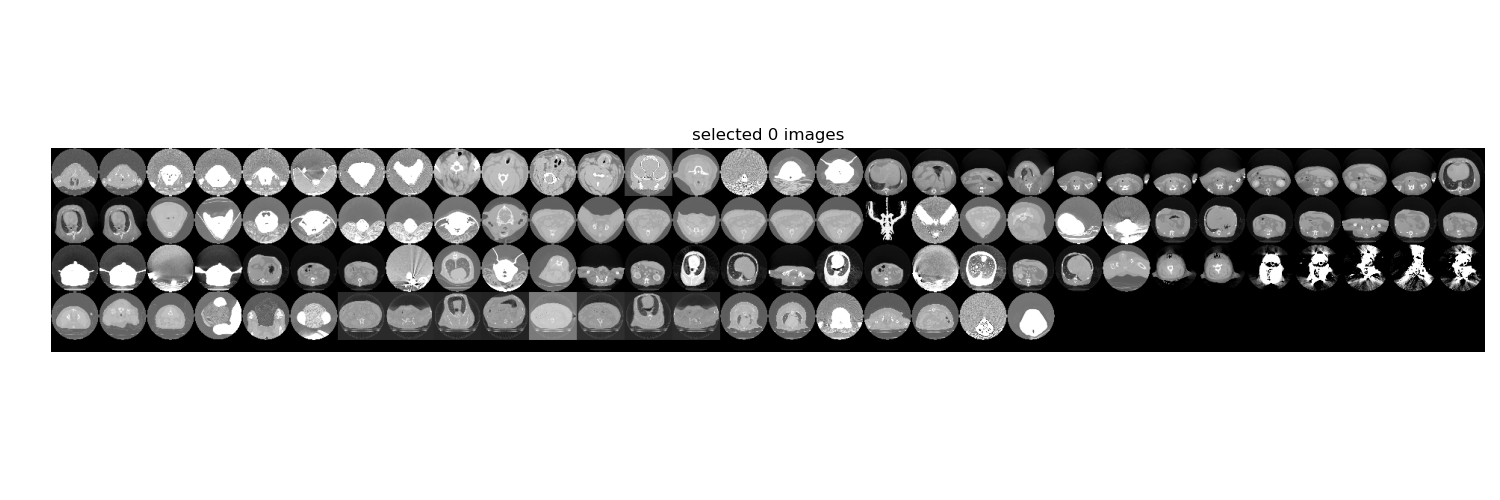

In [9]:
image_selection_gui = ImageSelection(
    faux_volume_image_files,
    image_file_list,
    figure_size=(15,5),
    selection_func=show_image,
)

In [10]:
selected_files = image_selection_gui.get_selected_images()
print(selected_files)

[]
